In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize
import re
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import logomaker

In [2]:
def simplify_motif_name(name):
    """
    """
#     new_name = name.split('/')[0]
    new_name = name.split('(')[0]
    return new_name

def simplify_enhclst_name(name):
    """
    """
    if name.startswith('clst'):
        name = name[4:]
    new_name = name.split('_')[0]
    return new_name

def p2f(text):
    """Convert percentage to float 
    """
    return np.float(text.strip('%'))/100

# Load data 

In [3]:
f_pattern = "/cndd2/fangming/software/homer/motifs/*.motif"
files = np.sort(glob.glob(f_pattern))

motif_pwms = {}
for file in files:
    df = pd.read_csv(file, sep='\t', skiprows=1, header=None)
    df.columns = ['A', 'C', 'G', 'T']
    
    with open(file, 'r') as fh:
        header = fh.readline()
        name = header.split('\t')[1]
        simp_name = simplify_motif_name(name) 
    
    if simp_name not in motif_pwms.keys():
        motif_pwms[simp_name] = df

all_motifs = np.sort(list(motif_pwms.keys()))
print(len(all_motifs))    
df.head() 

418


A      C      G      T
0  0.092  0.351  0.370  0.187
1  0.302  0.419  0.143  0.135
2  0.183  0.395  0.219  0.204
3  0.574  0.032  0.215  0.179
4  0.167  0.032  0.785  0.016

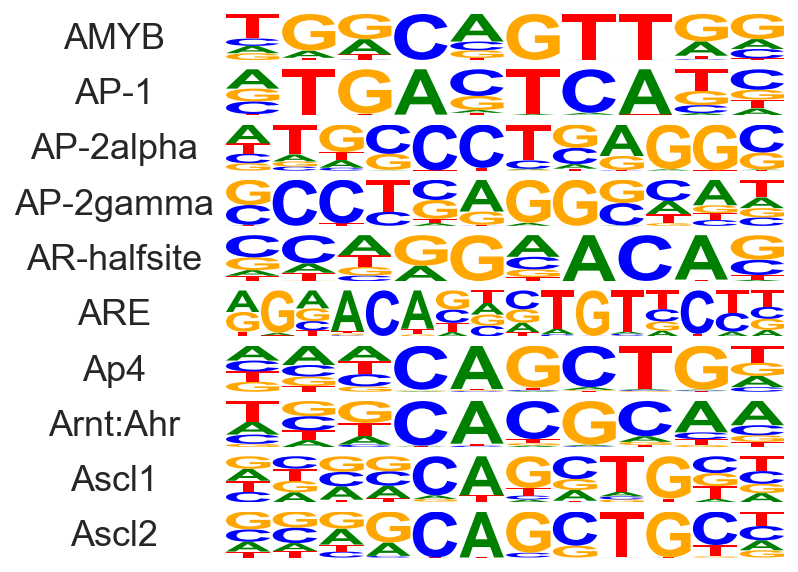

In [4]:
ntop = 10
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, all_motifs[:30]):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_coords(-0.2, 0.1,)
    
plt.show()

# Motif similarity score 
- a pair of motif; sliding against each other; KL divergence

In [5]:
def motif_kl_div(a, b, debug_mode=False):
    """Two motif PWMs (df, ACGT)
    """
    la, lb = len(a), len(b)
    # make sure motif a is larger
    if lb > la:
        a, b = b, a
        la, lb = lb, la
        
    af, bf = (a+1e-3).values, (b+1e-3).values
    if la == lb:
        score = np.sum(af*np.log2(af/bf))
        if debug_mode:
            return score, 0
        else:
            return score
            
    else:
        scores = [np.sum(af[i:lb+i]*np.log2(af[i:lb+i]/bf))
                    for i in np.arange(la-lb+1)
                 ]
        if debug_mode:
            return np.min(scores), np.argmin(scores)
        else:
            return np.min(scores)

In [6]:
import itertools

motif_distances = np.zeros((len(all_motifs), len(all_motifs)))
for i, a in enumerate(all_motifs):
    print('.', end='')
    if i%20 == 0:
        print('')
        
    for j, b in enumerate(all_motifs):
        score = motif_kl_div(motif_pwms[a], motif_pwms[b])
        motif_distances[i,j] = score 

.
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
.................

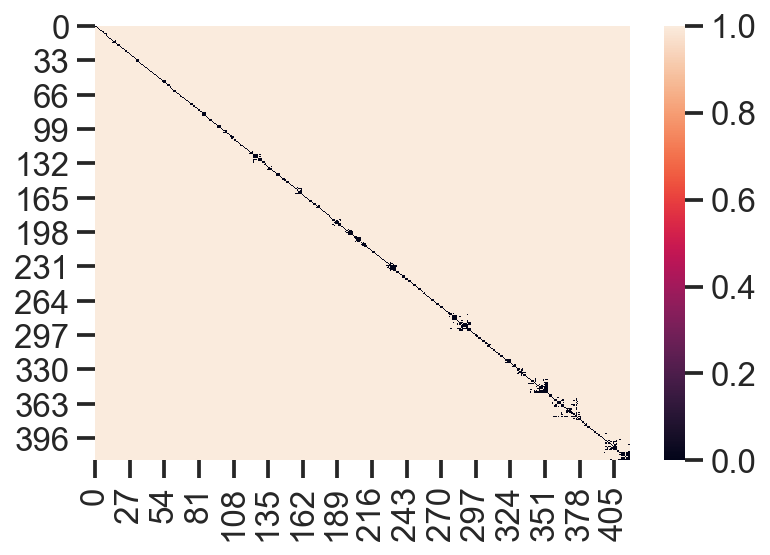

In [7]:
# sns.clustermap(motif_distances<3)

import scipy.cluster.hierarchy as sch

Z = sch.linkage(motif_distances[np.triu_indices(len(motif_distances), k=1)])
order = np.array(sch.dendrogram(Z, no_plot=True)['ivl']).astype(int)



fig, ax = plt.subplots()
sns.heatmap(motif_distances[order][:,order]>3, ax=ax)
plt.show()


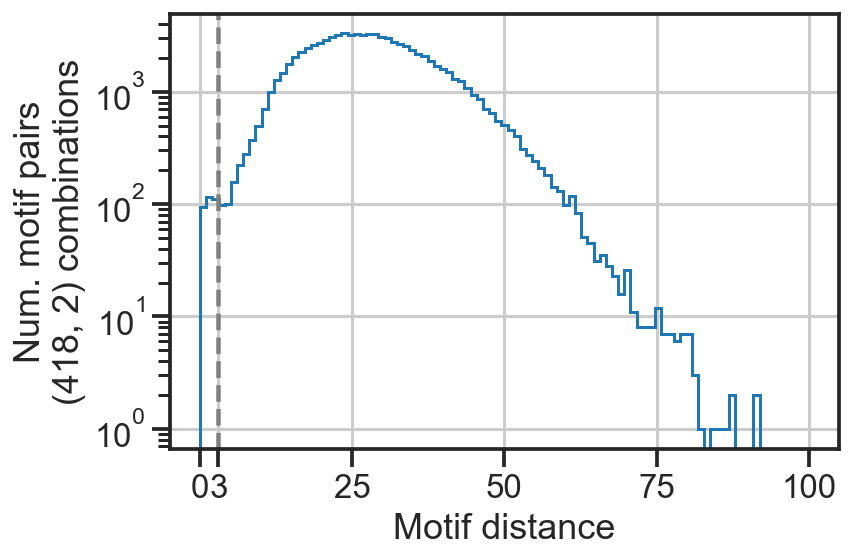

In [8]:
threshold = 3 

# distribution of motif similarity
fig, ax = plt.subplots()
g = ax.hist(motif_distances[np.triu_indices(len(motif_distances), k=1)], 
            bins=np.linspace(0, 100, 100), 
            histtype='step',
            density=False,
            label='a!=b',
           )
# _y, _x, _ = g
# ax.hist(np.diag(motif_distances), 
#         bins=np.linspace(0, 100, 100), 
#         histtype='step',
#         density=False,
#         label='a=b',
#        )

ax.axvline(threshold, color='gray', linestyle='--')
ax.set_yscale('log')
ax.set_xlabel('Motif distance')
ax.set_ylabel('Num. motif pairs\n({}, 2) combinations'.format(len(all_motifs)))
# ax.legend()

ax.set_xticks(np.sort(list(np.linspace(0, 100, 5)) + [threshold]))

plt.show()

318
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reo

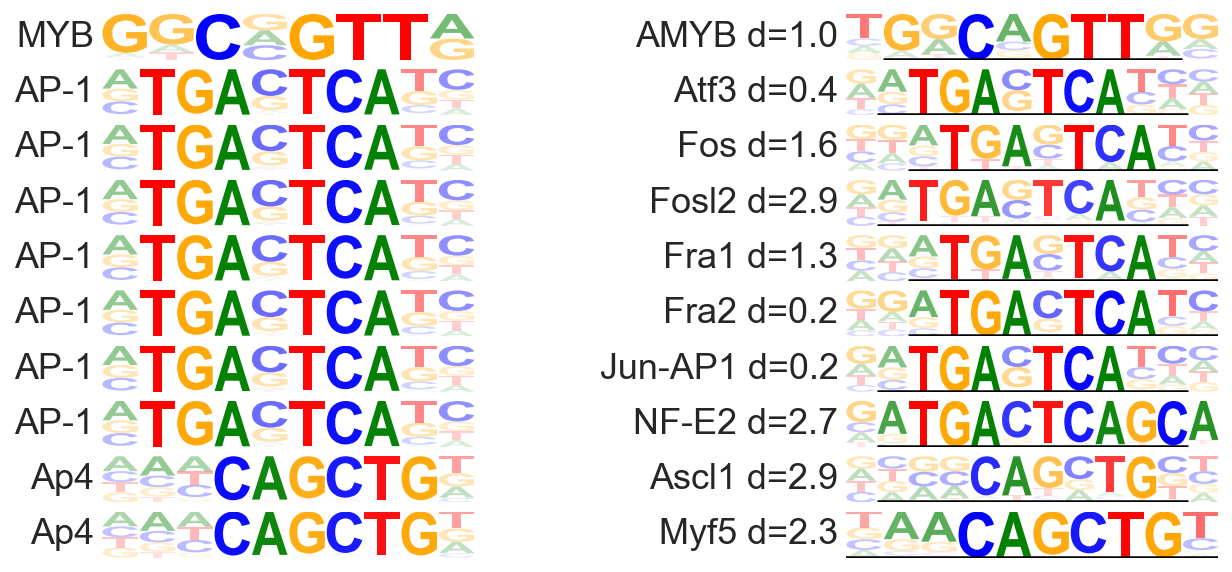

In [19]:
# plot all pairs with scores <
# threshold = 3 
indices = np.argwhere(np.logical_and(np.triu(motif_distances, k=1)>0, motif_distances<threshold))
print(len(indices))

ntop = 10
fig, axss = plt.subplots(ntop, 2, figsize=(5*2, 0.5*ntop))
for axs, idx in zip(axss, indices[:ntop]):
    
    motif_1, motif_2 = all_motifs[idx[0]], all_motifs[idx[1]]
    motifs = np.array([motif_1, motif_2])
    score, idx_min = motif_kl_div(motif_pwms[motif_1], motif_pwms[motif_2], debug_mode=True)
    lens = [len(motif_pwms[motif_1]), len(motif_pwms[motif_2])]
    idx_long_motif = np.argmax(lens)
    
    
    for i, (ax, motif) in enumerate(zip(axs, motifs[np.argsort(lens)])):
        
        g = logomaker.Logo(motif_pwms[motif], 
                           show_spines=False,
                           fade_probabilities=True,
                           ax=ax,
                           )
        ax.set_ylabel(motif, rotation=0, ha='right', va='center',)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 1:
            ax.hlines([0], xmin=idx_min-0.5, xmax=idx_min+np.min(lens)-0.5)
            ax.set_ylabel(motif+" d={:.1f}".format(score), rotation=0, ha='right', va='center',)
#             g.highlight_position_range(pmin=int(idx_min), 
#                                        pmax=int(idx_min+np.min(lens)), 
#                                        edgecolor='black',
#                                        color='white',
#                                       )
    
fig.subplots_adjust(wspace=1)
plt.show()

 Motif clusters 

In [10]:
import igraph

threshold = 3
indices = np.argwhere(np.logical_and(np.triu(motif_distances, k=1)>0, motif_distances<threshold))

# get connected motifs
G = igraph.Graph()
G.add_vertices(len(all_motifs))
G.add_edges(indices)

# motif clusters; ordered from big to small
clusters = np.array(G.clusters())
clusters = clusters[np.argsort([len(comp) for comp in clusters])[::-1]]

print(len(clusters), 
      len(np.hstack(clusters)),
      len(np.unique(np.hstack(clusters))),
     )

234 418 418


<ipython-input-10-89b19f9e67e0>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clusters = np.array(G.clusters())


In [11]:
# 
motif_clusters = []

output = '/cndd2/fangming/projects/scf_enhancers/results/homer_known_motif_clusters.txt'
output2 = '/cndd2/fangming/projects/scf_enhancers/results/homer_known_motif_clusters.pkl'
with open(output, 'w') as fh:
    for cluster in clusters:
        # 
        motifs = all_motifs[cluster]
        motif_lengths = [len(motif_pwms[motif]) for motif in motifs]

        # sort motifs by length
        motifs = motifs[np.argsort(motif_lengths)]
        motif_clusters.append(motifs)

        # 
        fh.write(",".join(motifs)+"\n")
        
with open (output2, 'wb') as fh2:
    pickle.dump(motif_clusters, fh2)

print("{} motifs, {} clusters".format(len(all_motifs), len(clusters)))

418 motifs, 234 clusters


0 0
0 1
0 2
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
0 3
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
0 4
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
1 0
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
1 1
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
1 2
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
1 3
1 4
2 0
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
2 1
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
2 2
2 3
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
2 4
3 0
3 1
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
3 2
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
3 3
in validate_matrix(): Row sums in df are not close to 1. Reormaliz

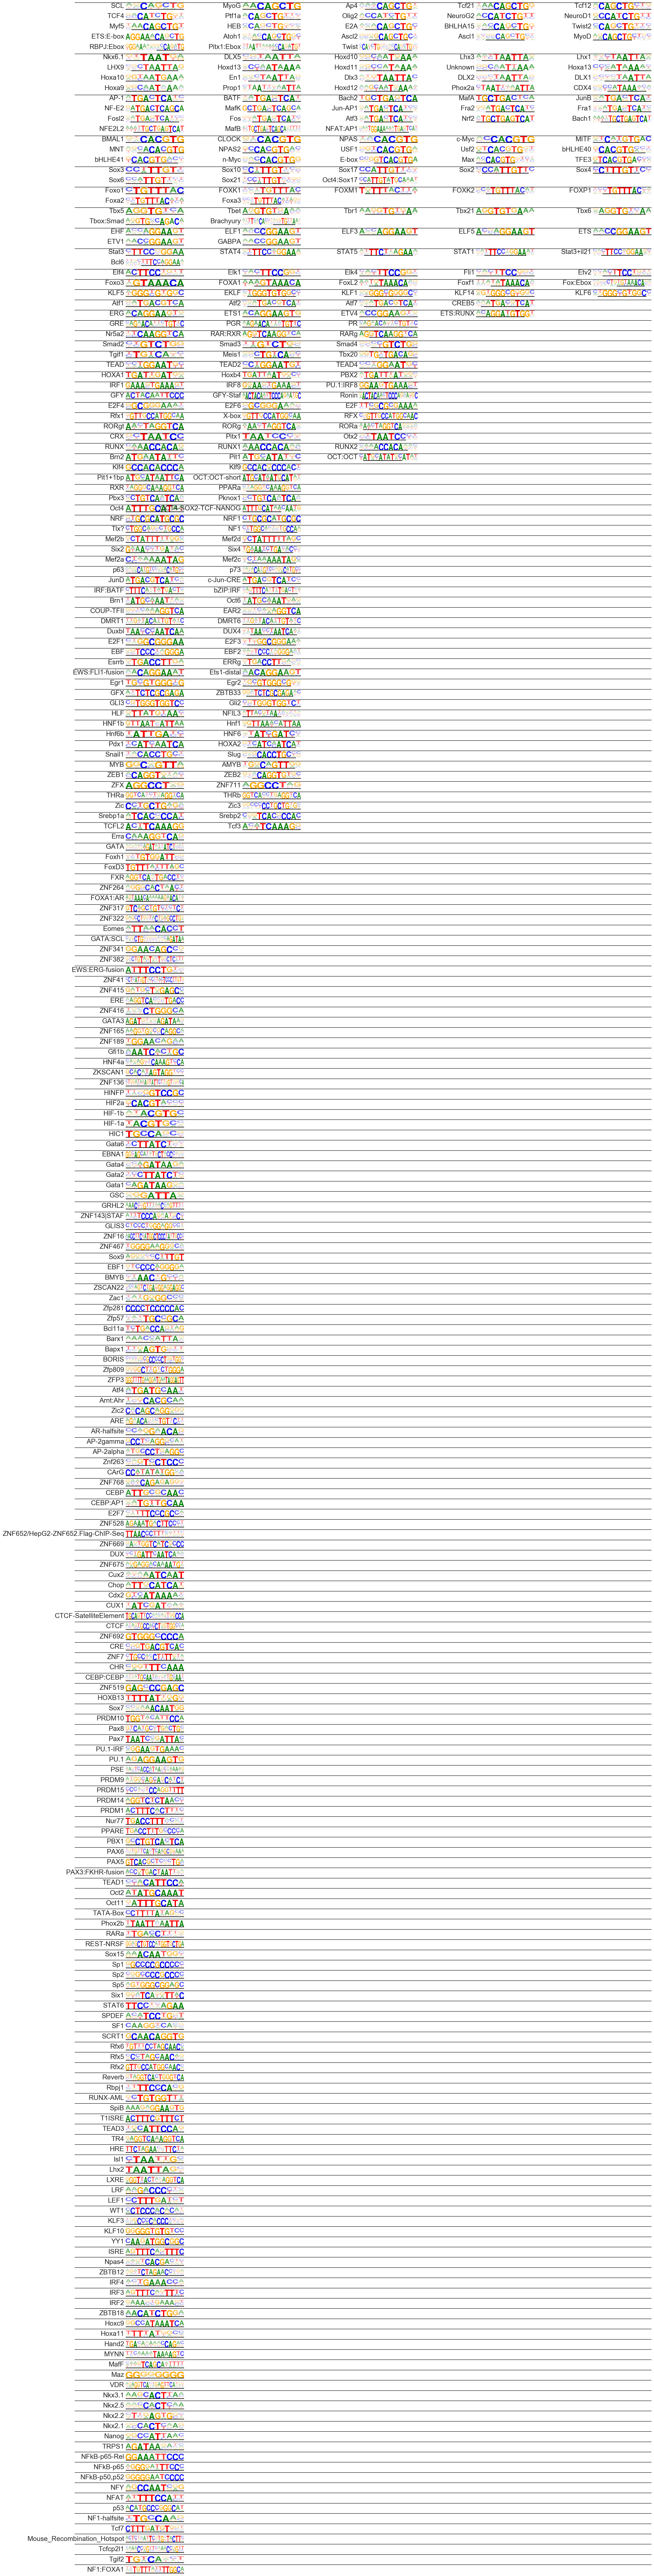

In [12]:
# plot all components
output_fig = ('/cndd2/fangming/projects/scf_enhancers/results/figures/'
              + 'homer_known_motif_clusters.pdf'
#               + 'homer_known_motif_clusters.png'
              )

motif_plots = motif_clusters #[3:3+5]
nrows = 5
ncols = np.sum([int((len(clst)+nrows-1)/nrows) for clst in motif_plots])

fig, axss = plt.subplots(ncols, nrows, figsize=(5*nrows, 0.5*ncols))
i = j = 0
for clst in motif_plots:
    # cluster line
    [[xmin, ymin], [xmax, ymax]] = axss[i,0].get_position().get_points()
    line = plt.Line2D((0.05,0.9),(ymax,ymax), color="black", linewidth=1)
    fig.add_artist(line)    
    
    # first motif
    first_motif = clst[0]
    
    for motif in clst:
        print(i, j)
        ax = axss[i,j]
        
        # get score and substring loc
        score, idx_min = motif_kl_div(motif_pwms[motif], motif_pwms[first_motif], 
                                      debug_mode=True)
        
        # logo
        g = logomaker.Logo(motif_pwms[motif], 
                           show_spines=False,
                           fade_probabilities=True,
                           ax=ax,
                           )
        ax.set_ylabel(motif, rotation=0, ha='right', va='center',)
        ax.set_xticks([])
        ax.set_yticks([])
        # underline similar substring
        ax.hlines([0], xmin=idx_min-0.5, xmax=idx_min+len(motif_pwms[first_motif])-0.5, 
                  color='black', linewidth=3,
                 )
        
        ## this plot over; next plot
        j += 1
        if j!=0 and j%nrows == 0:
            i += 1
            j = 0
        
    ## this cluster over; next row
    ## remove remaining frames
    if j != 0:
        for ax in axss[i,j:]:
            ax.axis('off')
        i += 1
        j = 0
    
fig.subplots_adjust(wspace=1, hspace=0.5)
# fig.savefig(output_fig)
snmcseq_utils.savefig(fig, output_fig)

# Debugging 

In [13]:
motif, first_motif = "Foxo1", "FOXM1"
motif_kl_div_dev(motif_pwms[motif], motif_pwms[first_motif])

NameError: name 'motif_kl_div_dev' is not defined

In [ ]:
score, idx_min
len(motif_pwms[motif]), len(motif_pwms[first_motif])

In [ ]:
def motif_kl_div_dev(a, b):
    """Two motif PWMs (df, ACGT)
    """
    la, lb = len(a), len(b)
    # make sure motif a is larger
    if lb > la:
        a, b = b, a
        la, lb = lb, la
        
    af, bf = (a+1e-3).values, (b+1e-3).values
    if la == lb:
        score = np.sum(af*np.log2(af/bf))
        return score, 0
            
    else:
        scores = [np.sum(af[i:lb+i]*np.log2(af[i:lb+i]/bf))
                    for i in np.arange(la-lb+1)
                 ]
#         return np.min(scores), np.argmin(scores)
        return scores, np.argmin(scores) 

# further improvement
# not necessarily slide from 0 to la-lb; can be expanded; also need to add non-overlapping bits